<!-- Notebook title -->
# Title

# 1. Notebook Description

### 1.1 Task Description
<!-- 
- A brief description of the problem you're solving with machine learning.
- Define the objective (e.g., classification, regression, clustering, etc.).
-->

TODO

### 1.2 Useful Resources
<!--
- Links to relevant papers, articles, or documentation.
- Description of the datasets (if external).
-->

### 1.2.1 Data

#### 1.2.1.1 Common

* [Datasets Kaggle](https://www.kaggle.com/datasets)  
  &nbsp;&nbsp;&nbsp;&nbsp;A vast repository of datasets across various domains provided by Kaggle, a platform for data science competitions.
  
* [Toy datasets from Sklearn](https://scikit-learn.org/stable/datasets/toy_dataset.html)  
  &nbsp;&nbsp;&nbsp;&nbsp;A collection of small datasets that come with the Scikit-learn library, useful for quick prototyping and testing algorithms.
  
* [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php)  
  &nbsp;&nbsp;&nbsp;&nbsp;A widely-used repository for machine learning datasets, with a variety of real-world datasets available for research and experimentation.
  
* [Google Dataset Search](https://datasetsearch.research.google.com/)  
  &nbsp;&nbsp;&nbsp;&nbsp;A tool from Google that helps to find datasets stored across the web, with a focus on publicly available data.
  
* [AWS Public Datasets](https://registry.opendata.aws/)  
  &nbsp;&nbsp;&nbsp;&nbsp;A registry of publicly available datasets that can be analyzed on the cloud using Amazon Web Services (AWS).
  
* [Microsoft Azure Open Datasets](https://azure.microsoft.com/en-us/services/open-datasets/)  
  &nbsp;&nbsp;&nbsp;&nbsp;A collection of curated datasets from various domains, made available by Microsoft Azure for use in machine learning and analytics.
  
* [Awesome Public Datasets](https://github.com/awesomedata/awesome-public-datasets)  
  &nbsp;&nbsp;&nbsp;&nbsp;A GitHub repository that lists a wide variety of datasets across different domains, curated by the community.
  
* [Data.gov](https://www.data.gov/)  
  &nbsp;&nbsp;&nbsp;&nbsp;A portal to the US government's open data, offering access to a wide range of datasets from various federal agencies.
  
* [Google BigQuery Public Datasets](https://cloud.google.com/bigquery/public-data)  
  &nbsp;&nbsp;&nbsp;&nbsp;Public datasets hosted by Google BigQuery, allowing for quick and powerful querying of large datasets in the cloud.
  
* [Papers with Code](https://paperswithcode.com/datasets)  
  &nbsp;&nbsp;&nbsp;&nbsp;A platform that links research papers with the corresponding code and datasets, helping researchers reproduce results and explore new data.
  
* [Zenodo](https://zenodo.org/)  
  &nbsp;&nbsp;&nbsp;&nbsp;An open-access repository that allows researchers to share datasets, software, and other research outputs, often linked to academic publications.
  
* [The World Bank Open Data](https://data.worldbank.org/)  
  &nbsp;&nbsp;&nbsp;&nbsp;A comprehensive source of global development data, with datasets covering various economic and social indicators.
  
* [OpenML](https://www.openml.org/)  
  &nbsp;&nbsp;&nbsp;&nbsp;An online platform for sharing datasets, machine learning experiments, and results, fostering collaboration in the ML community.
  
* [Stanford Large Network Dataset Collection (SNAP)](https://snap.stanford.edu/data/)  
  &nbsp;&nbsp;&nbsp;&nbsp;A collection of large-scale network datasets from Stanford University, useful for network analysis and graph-based machine learning.
  
* [KDnuggets Datasets](https://www.kdnuggets.com/datasets/index.html)  
  &nbsp;&nbsp;&nbsp;&nbsp;A curated list of datasets for data mining and data science, compiled by the KDnuggets community.


#### 1.2.1.2 Project

### 1.2.2 Learning

* [K-Nearest Neighbors on Kaggle](https://www.kaggle.com/code/mmdatainfo/k-nearest-neighbors)

* [Complete Guide to K-Nearest-Neighbors](https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor)

### 1.2.3 Documentation

---

# 2. Setup

## 2.1 Imports
<!--
- Import necessary libraries (e.g., `numpy`, `pandas`, `matplotlib`, `scikit-learn`, etc.).
-->

In [1]:

import torch
import torchvision
import torchvision.transforms as transforms
import json

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
from PIL import Image
from torch.utils.data import Dataset, DataLoader

import skimage

/home/jiskaanoy/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2.2 Global Variables
<!--
- Define global constants, paths, and configuration settings used throughout the notebook.
-->

---

# 4. Data Processing

In [2]:
import os
import json
import torch
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import cv2
import random
import torchvision.transforms.functional as F

class BalloonsDataset(Dataset):
    def __init__(self, json_file, img_dir, transforms=None):
        # Load the JSON annotations
        with open(json_file) as f:
            self.data = json.load(f)
        
        self.img_dir = img_dir
        self.transforms = transforms
        self.image_ids = list(self.data.keys())  # Get the image filenames from the JSON keys

    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        # Get image filename
        img_id = self.image_ids[idx]
        img_info = self.data[img_id]
        img_filename = img_info['filename']
        
        # Load the image
        img_path = os.path.join(self.img_dir, img_filename)
        img = Image.open(img_path).convert("RGB")
        
        # Get the regions (objects in the image)
        regions = img_info['regions']
        
        # Initialize lists to store bounding boxes, masks, and labels
        boxes = []
        masks = []
        labels = []
        
        # Process each region (each object)
        for region in regions.values():
            shape_attributes = region['shape_attributes']
            all_points_x = shape_attributes['all_points_x']
            all_points_y = shape_attributes['all_points_y']
            
            # Create the polygon mask for the balloon
            mask = np.zeros((img.height, img.width), dtype=np.uint8)
            points = np.array([list(zip(all_points_x, all_points_y))], dtype=np.int32)
            cv2.fillPoly(mask, points, 1)  # Fill the polygon with 1s in the mask
            
            # Convert polygon to bounding box [x_min, y_min, x_max, y_max]
            x_min = min(all_points_x)
            y_min = min(all_points_y)
            x_max = max(all_points_x)
            y_max = max(all_points_y)
            
            # Add the bounding box, mask, and label (1 for balloon)
            boxes.append([x_min, y_min, x_max, y_max])
            masks.append(mask)
            labels.append(1)  # Only one class: balloon

        # Convert everything to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        # Compute the area of the bounding boxes
        areas = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        # Assume all instances are not crowd
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)
        
        # Add image_id
        image_id = torch.tensor([idx])
        
        # Convert masks to PIL images for transformations
        masks = [Image.fromarray(mask) for mask in masks]
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': image_id,
            'area': areas,
            'iscrowd': iscrowd
        }
        
        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target

# Custom transformation classes (with updated ToTensor)
class ToTensor(object):
    def __call__(self, img, target):
        img = F.to_tensor(img)
        if 'masks' in target:
            # Convert each mask to a tensor and stack them
            masks = [torch.as_tensor(np.array(mask), dtype=torch.uint8) for mask in target['masks']]
            target['masks'] = torch.stack(masks, dim=0)
        return img, target
        return img, target

# Custom transformation classes
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, target):
        for t in self.transforms:
            img, target = t(img, target)
        return img, target

class RandomHorizontalFlip(object):
    def __init__(self, flip_prob=0.5):
        self.flip_prob = flip_prob

    def __call__(self, img, target):
        if random.random() < self.flip_prob:
            img = F.hflip(img)
            width = img.width
            # Flip bounding boxes
            if 'boxes' in target:
                boxes = target['boxes']
                boxes = boxes.clone()
                boxes[:, [0, 2]] = width - boxes[:, [2, 0]]
                target['boxes'] = boxes
            # Flip masks
            if 'masks' in target:
                target['masks'] = [F.hflip(mask) for mask in target['masks']]
        return img, target

class Resize(object):
    def __init__(self, size):
        self.size = size  # (height, width)

    def __call__(self, img, target):
        # Get original size
        orig_width, orig_height = img.size  # (width, height)
        new_height, new_width = self.size  # (height, width)
        img = F.resize(img, (new_height, new_width))
        # Compute scale factors
        scale_x = new_width / orig_width
        scale_y = new_height / orig_height
        # Resize bounding boxes
        if 'boxes' in target:
            boxes = target['boxes']
            boxes = boxes.clone()
            boxes[:, 0] = boxes[:, 0] * scale_x
            boxes[:, 2] = boxes[:, 2] * scale_x
            boxes[:, 1] = boxes[:, 1] * scale_y
            boxes[:, 3] = boxes[:, 3] * scale_y
            target['boxes'] = boxes
        # Resize masks
        if 'masks' in target:
            target['masks'] = [F.resize(mask, (new_height, new_width), interpolation=Image.NEAREST) for mask in target['masks']]
        return img, target

class ColorJitter(object):
    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        self.transform = transforms.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue)

    def __call__(self, img, target):
        img = self.transform(img)
        return img, target



# Define your mean and std for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

class Normalize(object):
    def __call__(self, img, target):
        img = F.normalize(img, mean=mean, std=std)
        return img, target

# Now define your transforms
train_transform = Compose([
    Resize((224, 224)),
    # Uncomment the following lines if you wish to include these transformations
    # RandomHorizontalFlip(flip_prob=0.5),
    # RandomRotation(degrees=15),
    ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    ToTensor(),
    Normalize(),
])

test_transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(),
])


In [3]:
# read json file root=f"{paths['PATH_COMMON_DATASETS']}/balloon_dataset/balloon/train/via_region_data.json"

with open(f"balloon/train/via_region_data.json") as f:
    data = json.load(f)



In [4]:

# get the image names and the corresponding list of coordinates from all_points_x and all_points_y for each region in the json file
image_names = list(data.keys())
image_names
coordinates = []
for image_name in image_names:
    regions = data[image_name]['regions']
    for region_index in regions:
        coordinates.append((image_name, regions[region_index]['shape_attributes']['all_points_x'], regions[region_index]['shape_attributes']['all_points_y']))
        

In [5]:
# Define a collate function for handling batches with varying sizes
def collate_fn(batch):
    return tuple(zip(*batch))

# DataLoader creation function
def get_balloons_loader(json_file, img_dir, batch_size=4, shuffle=True, num_workers=4, transforms=None):
    # Apply default transformation if none is provided
    if transforms is None:
        transforms = transforms.ToTensor()  # Default transformation to convert PIL images to tensors
    
    dataset = BalloonsDataset(json_file=json_file, img_dir=img_dir, transforms=transforms)
    
    # Create the DataLoader
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        collate_fn=collate_fn  # Use the defined collate_fn instead of a lambda
    )
    
    return data_loader
    

In [6]:
# train
# Path to your annotations JSON file and images directory

train_json_file = f"balloon/train/via_region_data.json"
train_img_dir = f"balloon/train"

# Create the DataLoader
train_data_loader = get_balloons_loader(train_json_file, train_img_dir, batch_size=16, num_workers=0,transforms=train_transform,
                                    
                                       )

# test
# Path to your annotations JSON file and images directory
test_json_file = f"balloon/val/via_region_data.json"
test_img_dir = f"balloon/val"

# Create the DataLoader
test_data_loader = get_balloons_loader(test_json_file, test_img_dir, batch_size=4, num_workers=0, transforms=test_transform)





        


## 4.2 Data inspection
<!--
- Preview the data (e.g., `head`, `describe`).
-->

# 5. Model Development

In [7]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
def get_model_instance_segmentation(num_classes):
    # Load a pre-trained model using the new weights parameter
    weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT  # Use the COCO-trained weights
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=weights)

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one (for your custom classes)
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 224  # Keep the hidden layer the same as the default

    # Replace the mask predictor with a new one (for your custom classes)
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
   # for param in model.parameters():
    #    param.requires_grad = True

    return model
    

In [8]:
num_classes = 2  # 1 class (balloon) + background
model = get_model_instance_segmentation(num_classes)


In [9]:
# Set the device (use GPU if available)
num_classes = 2  # 1 class (balloon) + background


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
import torch.optim as optim
# Move model to the right device
model.to(device)



# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)


# Set the number of epochs
num_epochs = 300

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    sum_loss = 0.0
    # Iterate through the DataLoader
    for images, targets in train_data_loader:
        images = [image.to(device) for image in images]  # Move images to device (GPU/CPU)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  # Move targets to device

        

        # Forward pass
        loss_dict = model(images, targets)
      
        # Total loss
        losses = sum(loss for loss in loss_dict.values())
        
   

        # Zero the gradients before the backward pass
   
        sum_loss += losses.item()
        # Backward pass

        
        losses.backward()
      
      

        # Clip the gradients to prevent exploding gradients
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

     
        optimizer.step()
        optimizer.zero_grad()

    
    print(f"Epoch {epoch+1}, Loss: {sum_loss:.4f}")

    

    # evaluate the model

            


Epoch 1, Loss: 9.0278
Epoch 2, Loss: 5.5245
Epoch 3, Loss: 5.1401
Epoch 4, Loss: 4.8988
Epoch 5, Loss: 4.7825
Epoch 6, Loss: 4.5468
Epoch 7, Loss: 4.0161
Epoch 8, Loss: 3.7588
Epoch 9, Loss: 3.1074
Epoch 10, Loss: 2.8511
Epoch 11, Loss: 2.5162
Epoch 12, Loss: 2.1316
Epoch 13, Loss: 1.9237
Epoch 14, Loss: 1.7236
Epoch 15, Loss: 1.4819
Epoch 16, Loss: 1.3269
Epoch 17, Loss: 1.1518
Epoch 18, Loss: 1.0785
Epoch 19, Loss: 1.0082
Epoch 20, Loss: 0.9242
Epoch 21, Loss: 0.9155
Epoch 22, Loss: 0.8920
Epoch 23, Loss: 0.8022
Epoch 24, Loss: 0.8353
Epoch 25, Loss: 0.7690
Epoch 26, Loss: 0.7669
Epoch 27, Loss: 0.7528
Epoch 28, Loss: 0.7264
Epoch 29, Loss: 0.7100
Epoch 30, Loss: 0.7074


KeyboardInterrupt: 

## 5.1 Model Selection
<!--
- Choose the model(s) to be trained (e.g., linear regression, decision trees, neural networks).
-->

## 5.2 Model Training
<!--
- Train the selected model(s) using the training data.
-->

## 5.3 Model Evaluation
<!--
- Evaluate model performance on validation data.
- Use appropriate metrics (e.g., accuracy, precision, recall, RMSE).
-->

In [10]:
# Set the model to evaluation mode
model.eval()

# Move the model to the appropriate device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.eval()

# Disable gradient calculation for inference
with torch.no_grad():
    for images, _ in train_data_loader:
        # Move images to device (GPU/CPU)
        images = [image.to(device) for image in images]

        # Forward pass (inference)
        predictions = model(images)

        # Display predictions for the first image in the batch
        print("Predictions for the first image:")
        print(predictions[0])

        # Example to display some details
        boxes = predictions[0]['boxes']  # Bounding boxes
        labels = predictions[0]['labels']  # Labels for each object
        masks = predictions[0]['masks']  # Segmentation masks

        print(f"Bounding Boxes: {boxes}")
        print(f"Labels: {labels}")
#        print(f"Masks: {masks.shape}")  # Masks should have shape [N, H, W]

   #     break  # We just want to test the first batch for now


Predictions for the first image:
{'boxes': tensor([[108.0889, 100.2364, 118.8856, 120.2889]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0'), 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')}
Bounding Boxes: tensor([[108.0889, 100.2364, 118.8856, 120.2889]], device='cuda:0')
Labels: tensor([1], device='cuda:0')
Predictions for the first image:
{'boxes': tensor([[119.3083, 110.9914, 160.5305, 154.6455]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0'), 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0

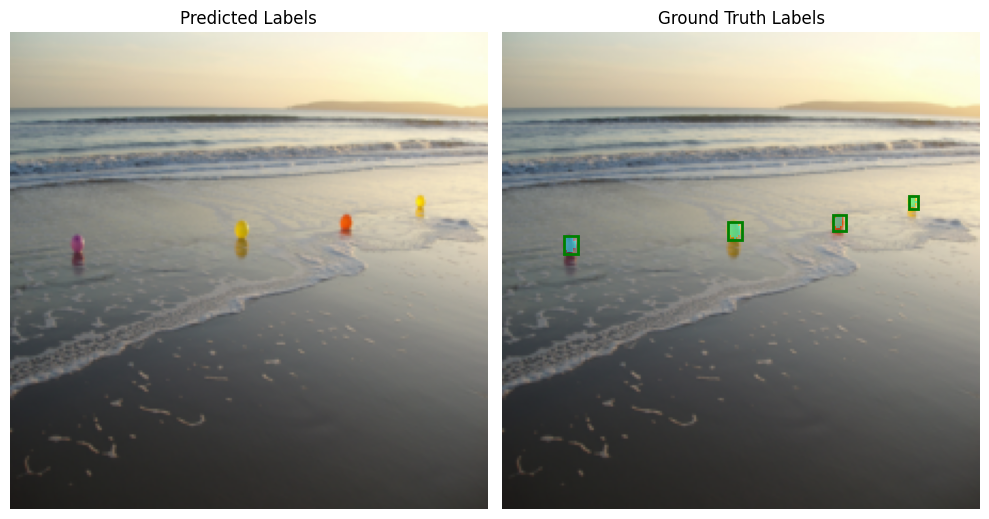

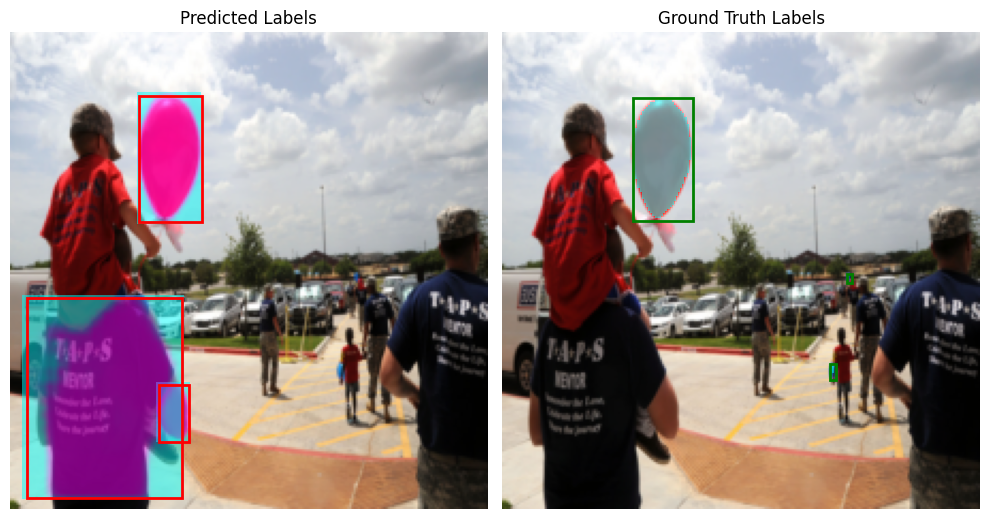

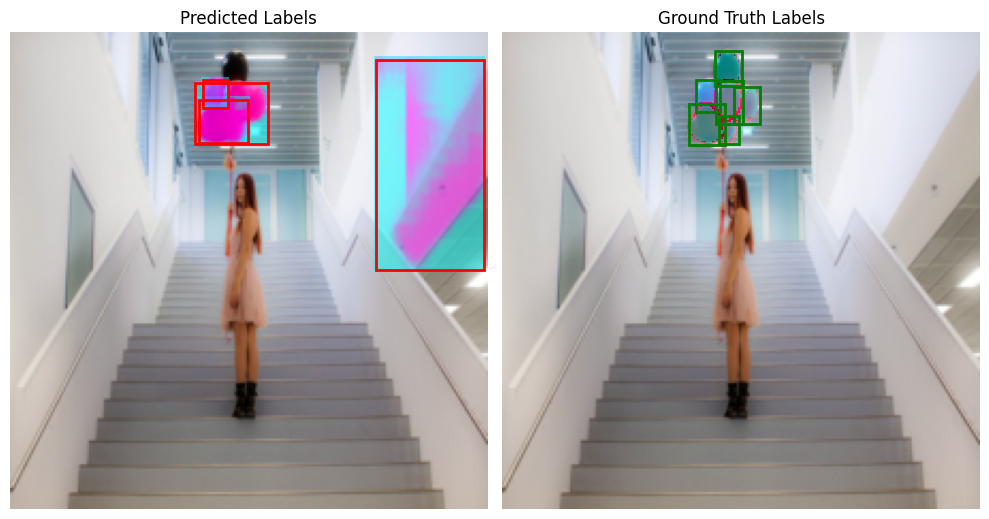

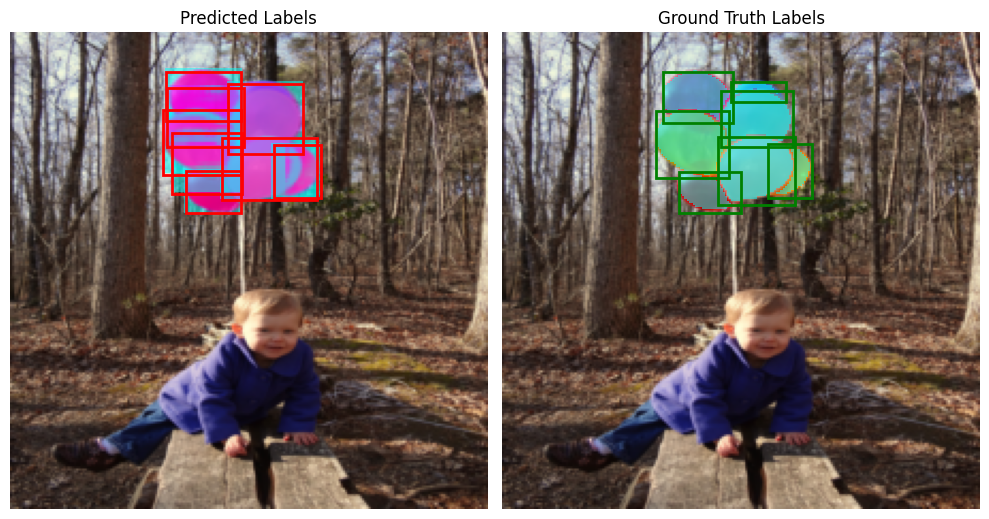

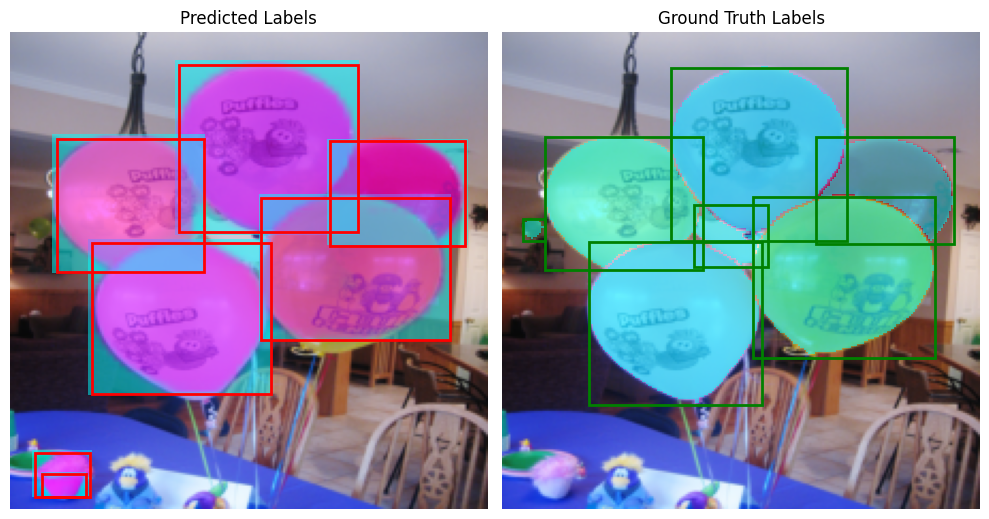

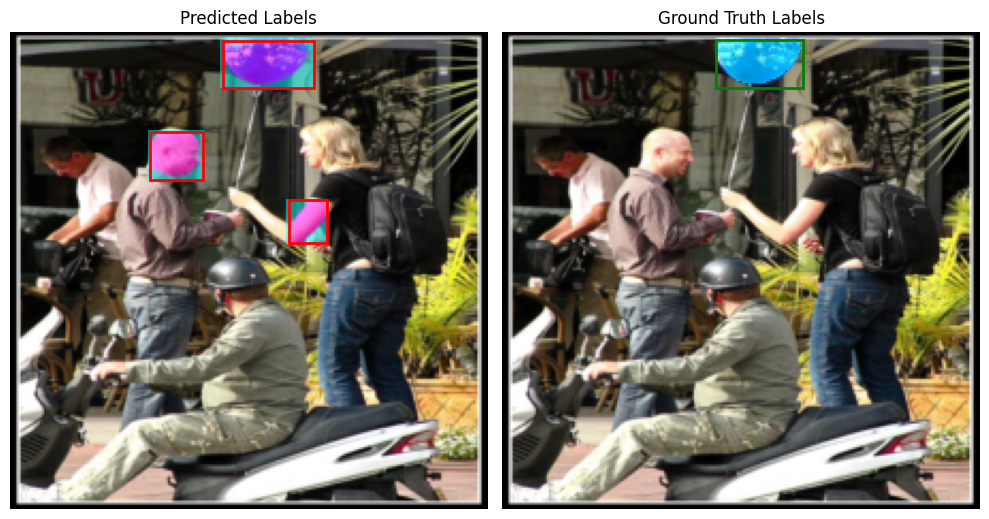

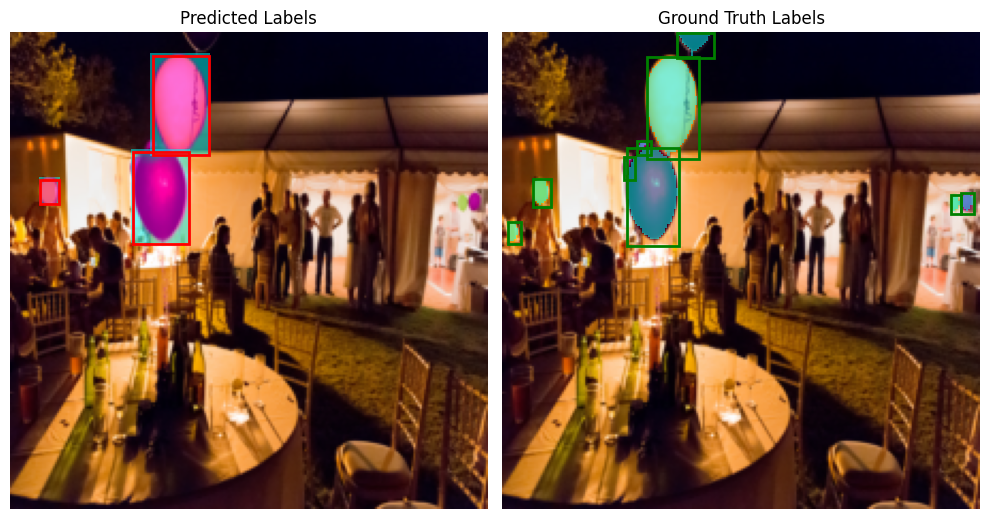

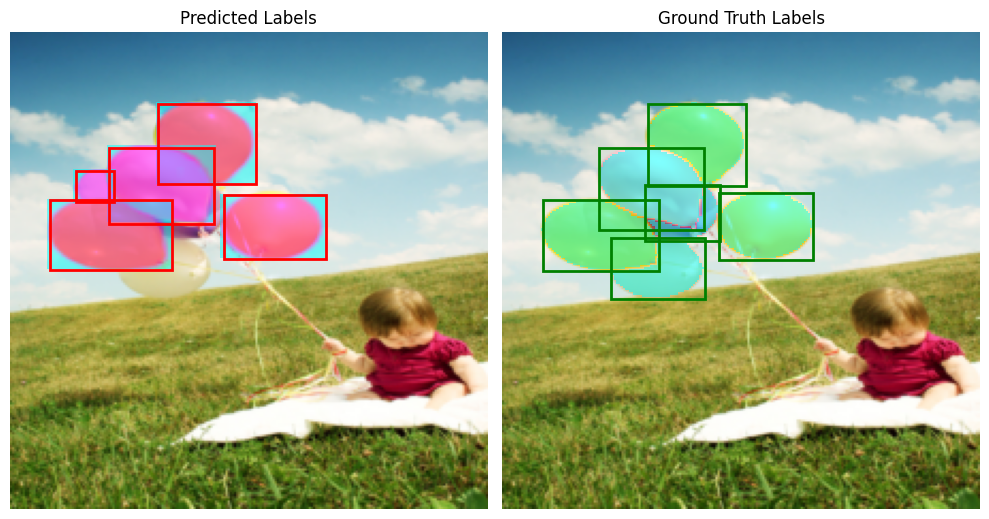

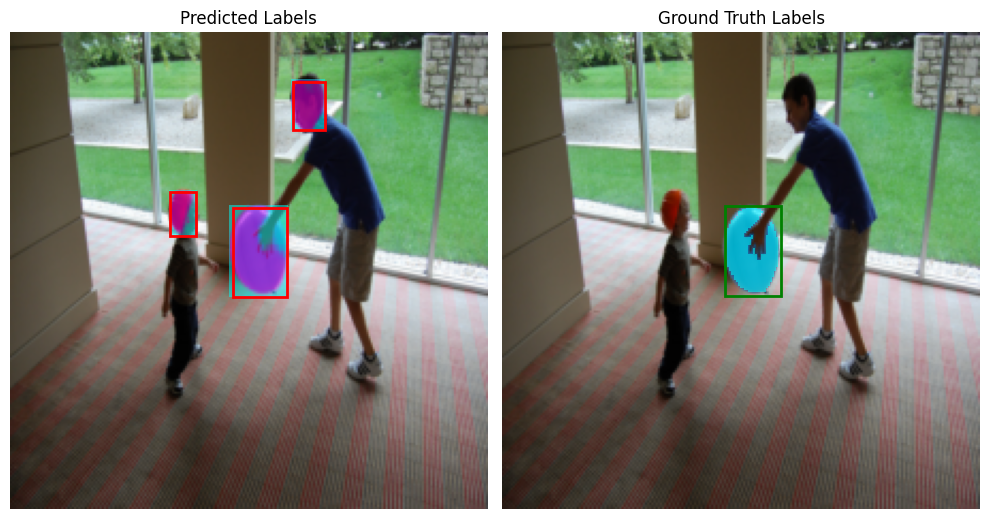

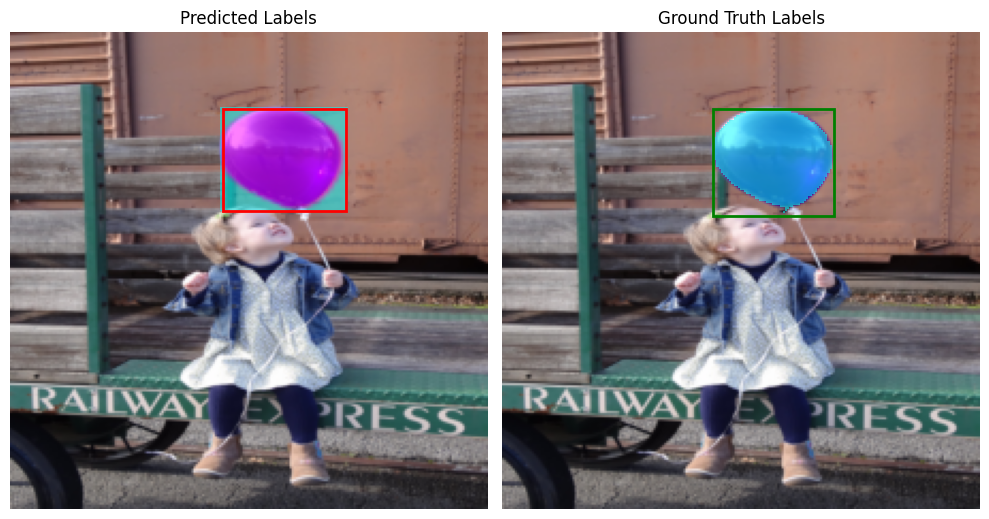

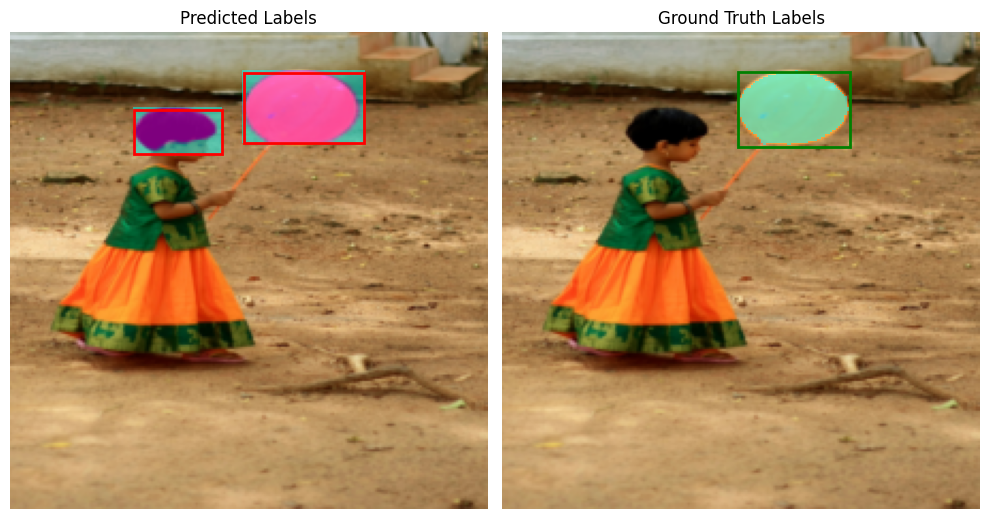

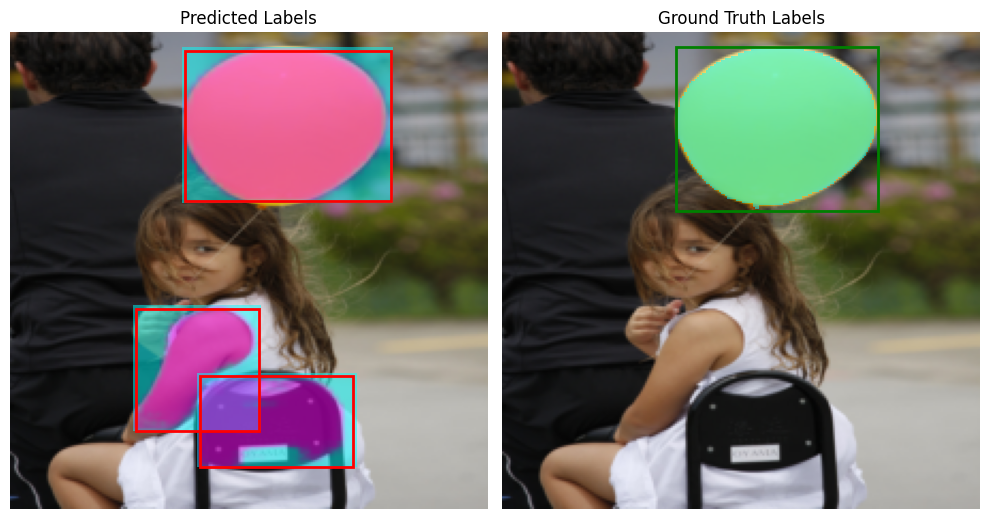

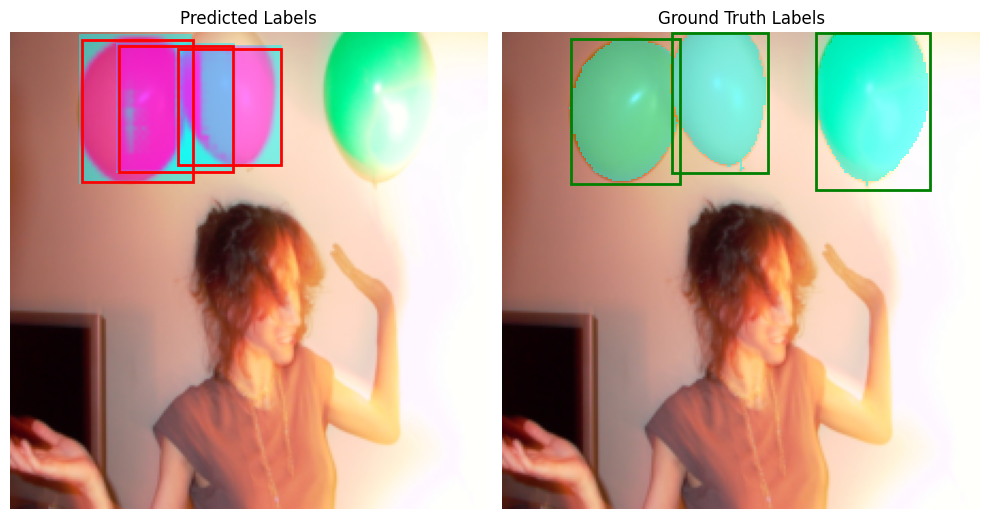

In [12]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def denormalize(image_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Denormalize an image tensor by reversing the normalization."""
    image = image_tensor.clone()
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)  # Reverse normalization
    return image

def visualize_image_with_masks_side_by_side(image_tensor, pred_masks, pred_boxes, pred_scores, gt_masks, gt_boxes, threshold=0.0):
    """Visualize side-by-side predictions and ground truth masks."""
    # De-normalize the image
    image = denormalize(image_tensor).cpu().detach()

    # Convert from (C, H, W) to (H, W, C)
    if image.shape[0] == 3:
        image = image.permute(1, 2, 0)

    image = torch.clamp(image, 0, 1).numpy()

    # Create two equally sized subplots for side-by-side comparison
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))

    # Predicted Labels
    axs[0].imshow(image)
    axs[0].axis('off')
    axs[0].set_title('Predicted Labels')

    # Plot predicted masks and bounding boxes
    for i in range(pred_masks.shape[0]):
        if pred_scores[i] >= threshold:
            mask = pred_masks[i, 0].cpu().detach().numpy()
            mask = np.ma.masked_where(mask == 0, mask)
            axs[0].imshow(mask, cmap='cool', alpha=0.5)

            box = pred_boxes[i].cpu().detach().numpy()
            x_min, y_min, x_max, y_max = box
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, color='red', linewidth=2)
            axs[0].add_patch(rect)

    # Ground Truth Labels
    axs[1].imshow(image)
    axs[1].axis('off')
    axs[1].set_title('Ground Truth Labels')

    # Plot ground truth masks and bounding boxes
    for i in range(gt_masks.shape[0]):
        mask = gt_masks[i].cpu().detach().numpy()
        mask = np.ma.masked_where(mask == 0, mask)
        axs[1].imshow(mask, cmap='cool', alpha=0.5)

        box = gt_boxes[i].cpu().detach().numpy()
        x_min, y_min, x_max, y_max = box
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, color='green', linewidth=2)
        axs[1].add_patch(rect)

    plt.tight_layout()
    plt.show()

# Model evaluation and visualization
model.eval()

with torch.no_grad():
    for images, targets in test_data_loader:
        images = [image.to(device) for image in images]
        predictions = model(images)

        # For each image in the batch
        for idx in range(len(images)):
            image = images[idx]
            target = targets[idx]

            predicted_masks = predictions[idx]['masks']
            predicted_boxes = predictions[idx]['boxes']
            predicted_scores = predictions[idx]['scores']

            gt_masks = target['masks']
            gt_boxes = target['boxes']

            # Visualize the image with predicted and ground truth labels side by side
            visualize_image_with_masks_side_by_side(image, predicted_masks, predicted_boxes, predicted_scores, gt_masks, gt_boxes, threshold=0.0)

      #  break


## 5.4 Hyperparameter Tuning
<!--
- Fine-tune the model using techniques like Grid Search or Random Search.
- Evaluate the impact of different hyperparameters.
-->

## 5.5 Model Testing
<!--
- Evaluate the final model on the test dataset.
- Ensure that the model generalizes well to unseen data.
-->

## 5.6 Model Interpretation (Optional)
<!--
- Interpret the model results (e.g., feature importance, SHAP values).
- Discuss the strengths and limitations of the model.
-->

---

# 6. Predictions


## 6.1 Make Predictions
<!--
- Use the trained model to make predictions on new/unseen data.
-->

## 6.2 Save Model and Results
<!--
- Save the trained model to disk for future use.
- Export prediction results for further analysis.
-->

---

# 7. Documentation and Reporting

## 7.1 Summary of Findings
<!--
- Summarize the results and findings of the analysis.
-->

## 7.2 Next Steps
<!--
- Suggest further improvements, alternative models, or future work.
-->

## 7.3 References
<!--
- Cite any resources, papers, or documentation used.
-->